In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.pyplot import MultipleLocator # 设置刻度间隔

In [3]:
df = pd.read_csv('../data/group_data.csv')

In [4]:
df.head(1)
# lo la 相对坐标

,MRTime,Longitude,Latitude,RNCID_1,CellID_1,SignalLevel_1,RSSI_1,RNCID_2,CellID_2,SignalLevel_2,...,RNCID_7,CellID_7,SignalLevel_7,RSSI_7,LinkNum,id_c5ombine,Longitude_eng,Latitude_eng,lo,la
0,1.510000e+12,121.213563,31.291798,6188,26051,4,-59,6188,27394,3,...,6182.0,44754.0,3.0,-95.0,7,32239,121.211928,31.288649,0.001635,0.003149


In [4]:
# 按照主机站进行分组
data = df.groupby(['RNCID_1','CellID_1'])
# 查看分组后的信息：每组中的数据分布不均
print("每组的数据量：\n", sorted(data.size()))
data = list(data)  # 共43个组
print("总组数：", len(data))

每组的数据量：
 [3, 6, 7, 8, 8, 9, 9, 13, 14, 14, 15, 15, 22, 29, 38, 44, 50, 51, 67, 67, 80, 83, 92, 98, 98, 103, 124, 131, 132, 139, 142, 164, 201, 222, 237, 252, 283, 283, 354, 354, 378, 674, 819]
总组数： 43


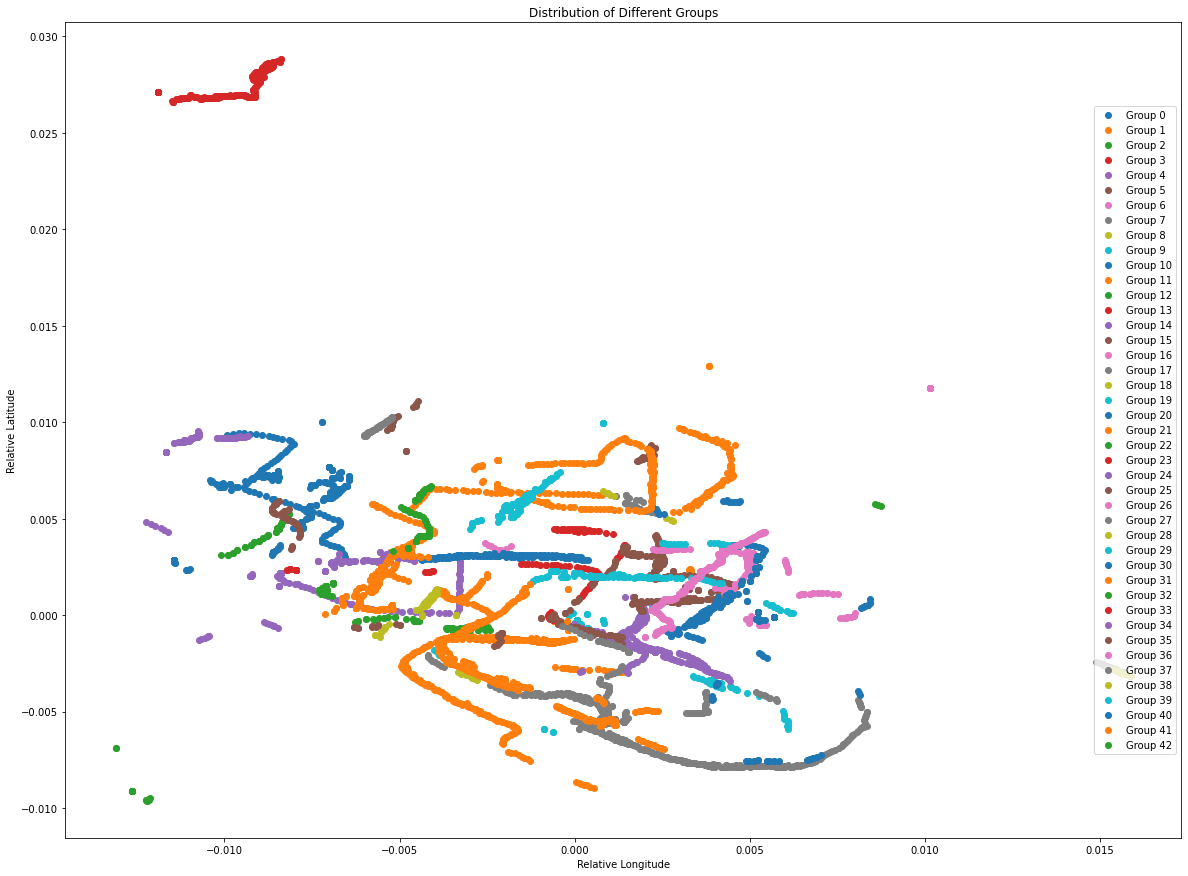

In [16]:
# 打印每一组的散点图，以此进行聚类分析
fig = plt.figure(figsize=(20,15))
plt.xlabel("Relative Longitude")
plt.ylabel("Relative Latitude")
for i in range(43):
    plt.scatter(data[i][1].loc[:, 'lo'], data[i][1].loc[:, 'la'],label = 'Group %s'%i)
plt.legend(loc='right')
plt.title('Distribution of Different Groups')
plt.show()

In [5]:
type(data[0][1])   # 第一组数据
g0 = data[0][1]
g0.head(1)

,MRTime,Longitude,Latitude,RNCID_1,CellID_1,SignalLevel_1,RSSI_1,RNCID_2,CellID_2,SignalLevel_2,...,RNCID_7,CellID_7,SignalLevel_7,RSSI_7,LinkNum,id_c5ombine,Longitude_eng,Latitude_eng,lo,la
1436,1.510000e+12,121.211999,31.285001,5198,16058,4,-81,5198,16237,4,...,-999.0,-999.0,-999.0,-999.0,3,21256,121.220639,31.281873,-0.00864,0.003128


In [21]:
# 设置栅格大小
grid_width = 0.001
grid_height = 0.001

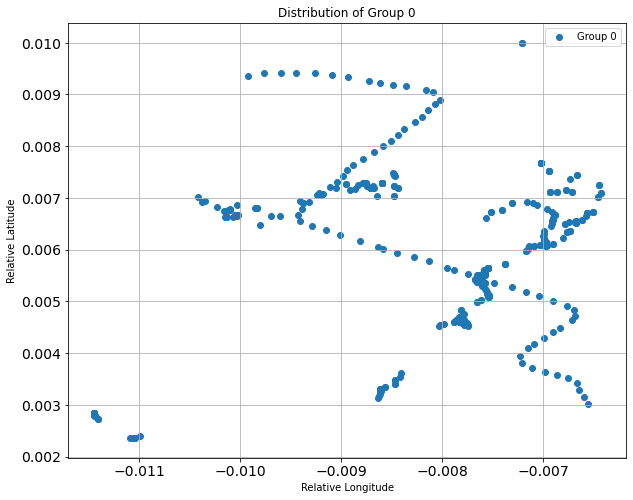

In [22]:
# 通过相对距离对主基站的数据划分栅格
fig = plt.figure(figsize=(10,8))
plt.xlabel("Relative Longitude")
plt.ylabel("Relative Latitude")
plt.scatter(g0.loc[:, 'lo'], g0.loc[:, 'la'],label = 'Group 0')
plt.grid()
plt.legend(loc='best')
# 绘制栅格
plt.tick_params(axis='both',which='major',labelsize=14)
x_major_locator=MultipleLocator(grid_width)
y_major_locator=MultipleLocator(grid_height)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.title('Distribution of Group 0')
plt.show()

### 最优K值

针对每个主基站分组后的MR数据，计算MR样本参考于该主基站的相对位置。利用所有MR数据的相对位置，设计和实现K-Means聚类方法，使得同簇内MR数据相对位置之间的相似度高、跨簇MR数据相对位置之间的相似度低，要求计算一个最优K值及其聚类结果；

- Target: 通过表征一个主基站内的数据特征(比如特征值是它的所有MR与他的相对距离的均值和方差)

In [6]:
#在图中，主基站位置为(0,0)  每一个MR数据的相对位置坐标 g0.loc[:, 'lo'], g0.loc[:, 'la']
# 计算每一个相对位置到主基站的距离
dist0 = []
for index, row in g0.iterrows():
    d = np.sqrt(row['lo']**2 + row['la']**2)
    dist0.append(d)
# 均值
print(np.mean(dist0))
# 方差
print(np.var(dist0))
# 标准差
print(np.std(dist0))

0.011040551965685772
1.3080537820870444e-06
0.0011437017889673183


In [5]:
# 选取所有组的特征信息
group_feature = []
for i in range(len(data)):
    dist = []
    for index, row in data[i][1].iterrows():
        d = np.sqrt(row['lo']**2 + row['la']**2)
        dist.append(d)
    group_feature.append([np.mean(dist), np.var(dist)])
print(group_feature[0])

[0.011040551965685848, 1.308053782087067e-06]


In [6]:
X = np.array(group_feature)
print(X.shape)

(43, 2)


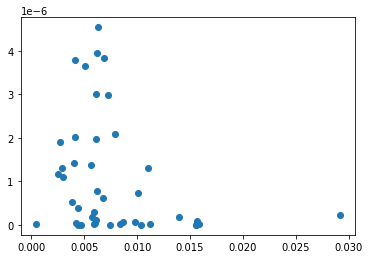

In [7]:
# 每组特征点分布
plt.scatter(X[:,0], X[:, 1], marker='o')
plt.show()

### 使用手肘法寻找最优的K值

手肘法的核心指标是SSE(sum of the squared errors，误差平方和)：
$$SSE = \sum_{i=1}^{k}\sum_{p\in C_i}|p-m_i|^2$$

其中，$C_i$是第$i$个簇，$p$是$C_i$中的样本点，$m_i$是$C_i$的质心（$C_i$中所有样本的均值），SSE是所有样本的聚类误差，代表了聚类效果的好坏。

手肘法的核心思想是：随着聚类数k的增大，样本划分会更加精细，每个簇的聚合程度会逐渐提高，那么误差平方和SSE自然会逐渐变小。并且，当k小于真实聚类数时，由于k的增大会大幅增加每个簇的聚合程度，故SSE的下降幅度会很大，而当k到达真实聚类数时，再增加k所得到的聚合程度回报会迅速变小，所以SSE的下降幅度会骤减，然后随着k值的继续增大而趋于平缓，也就是说SSE和k的关系图是一个手肘的形状，而这个肘部对应的k值就是数据的真实聚类数。当然，这也是该方法被称为手肘法的原因。

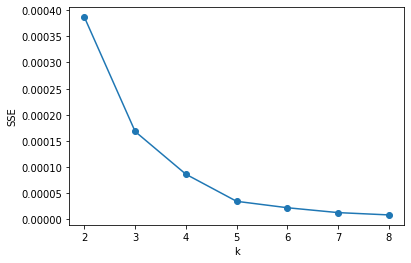

In [20]:
# 通过每一组的特征信息进行聚类
# 手肘法调优：
sse = []
for i in range(2,9):
    mid = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200)
    mid.fit(X)
    sse.append(mid.inertia_) #inertia为簇内误差平方和
        
plt.plot(range(2,9), sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

当聚类个数未达到最优个数k时，随着聚类个数的增加，SSE下降较快。达到最优个数以后，SSE下降缓慢。斜率最大处即为最优k值。上图显示了最优的聚类结果是3个。下面我们显示聚类的效果。

In [49]:
# K=3的聚类效果   训练
model = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=200)
model.fit(X)

KMeans(max_iter=200, n_clusters=3)

In [50]:
labels = model.labels_  # 获取聚类标签
cluster_centers = model.cluster_centers_  # 获取聚类中心
inertia = model.inertia_  # 获取聚类准则的总和
print("聚类标签：", labels)
print("聚类中心：", cluster_centers)
print("聚类准则：", inertia)

聚类标签： [1 0 1 2 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 1 0 0 0 0 0]
聚类中心： [[5.31545203e-03 1.35387120e-06]
 [1.29171159e-02 2.43954831e-07]
 [2.91968523e-02 2.19160736e-07]]
聚类准则： 0.00016789298141057498


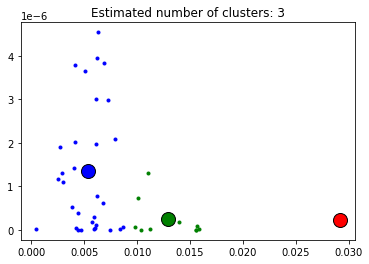

In [51]:
import matplotlib.pyplot as plt
from itertools import cycle

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

由于相对位置都比较小，所以这里对数据进行归一化处理

- 数据归一化：由于k-means算法依赖于距离，因此必须保证每个维度的距离单位一致。
- 数据标准化：转化为正态分布

In [25]:
# 因为相对坐标的数据都都较小，所有进行标准化处理 -- 感觉标准化处理之后计算好慢！！
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# 数据的归一化是无量纲化，也就是忽略掉特征之间值大小对最后结果带来的影响
# 准化是统一特征的数据分布，忽略掉不同分布的特征对最后结果带来的影响

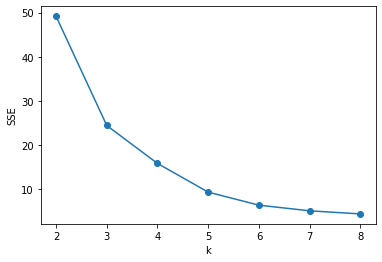

In [26]:
# 标准化处理
std = StandardScaler()
std_data = std.fit_transform(X)


# 手肘法调优：
sse = []
for i in range(2,9):
    mid = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200)
    mid.fit(std_data)
    sse.append(mid.inertia_) #inertia为簇内误差平方和
        
plt.plot(range(2,9), sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

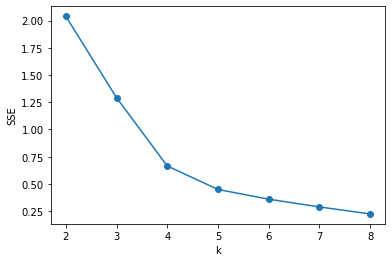

In [27]:
# 归一化
minmax = MinMaxScaler()
scaler_data = minmax.fit_transform(X)

# 手肘法调优：
sse = []
for i in range(2,9):
    mid = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200)
    mid.fit(scaler_data)
    sse.append(mid.inertia_) #inertia为簇内误差平方和
        
plt.plot(range(2,9), sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

0.6644810230818553


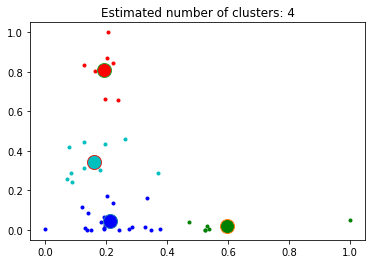

In [53]:
# 归计划处理有最优k值是4，绘制聚类结果

model = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=200)
model.fit(scaler_data)

labels = model.labels_  # 获取聚类标签
cluster_centers = model.cluster_centers_  # 获取聚类中心
inertia = model.inertia_  # 获取聚类准则的总和

# print(labels)
# print(cluster_centers)
print(inertia)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykaaafawadad")

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(scaler_data[my_members, 0], scaler_data[my_members, 1], col + '.')
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()